# Check ensemble of OpenMM temperature replica exchange simulations

*Note: This notebook can be run locally by cloning the*
[Github repository](https://github.com/shirtsgroup/physical_validation).
*The notebook is located in* `doc/examples/openmm_replica_exchange.ipynb`. *The input and output files of the simulation are located in* `doc/examples/simulation_results/openMMTemperatureReplicaExchange/`.
*Be aware that probabilistic quantities such as error estimates based on bootstrapping
will differ when repeating the analysis.*

In [1]:
# enable plotting in notebook
%matplotlib notebook

Ensemble validation is particularly useful for validating enhanced sampling methods such
as temperature replica exchange (parallel tempering) molecular dynamics simulations. In
replica exchange MD, configurational swaps are attempted periodically between simulations
running concurrently in separate simulation cells at different temperatures. Since the
acceptance criteria for exchange moves depends on the energies of each replica involved,
it is critical that the energy distributions are correct at all thermodynamic states used
the parallel tempering scheme.

In this example, parallel tempering simulations on a simple coarse-grained oligomer system
were run using the openmmtools framework. 6 temperature states spaced logarithmically over 
the range of 300K to 500K, over which the oligomer undergoes a transition from a helix to 
unfolded state.

In [2]:
import numpy as np
import physical_validation

import openmmtools.multistate
import simtk.unit

For convenience, we will use native `physical_validation` units:

In [3]:
energy_unit = simtk.unit.kilojoule_per_mole
length_unit = simtk.unit.nanometer
volume_unit = length_unit ** 3
temperature_unit = simtk.unit.kelvin
pressure_unit = simtk.unit.bar
time_unit = simtk.unit.picosecond
kb = simtk.unit.MOLAR_GAS_CONSTANT_R.value_in_unit(energy_unit / temperature_unit)

Create the `UnitData` object which we will use to inform `physical_validation` of our choices. Note that the conversion factors will all be `1.0`, since we're using native units. The notation here is more general though, and would allow to change any unit set in the previous cell.

In [4]:
unit_data = physical_validation.data.UnitData(
    kb=kb,
    energy_conversion=energy_unit.conversion_factor_to(simtk.unit.kilojoule_per_mole),
    length_conversion=length_unit.conversion_factor_to(simtk.unit.nanometer),
    volume_conversion=volume_unit.conversion_factor_to(simtk.unit.nanometer ** 3),
    temperature_conversion=temperature_unit.conversion_factor_to(simtk.unit.kelvin),
    pressure_conversion=pressure_unit.conversion_factor_to(simtk.unit.bar),
    time_conversion=time_unit.conversion_factor_to(simtk.unit.picosecond),
    energy_str=energy_unit.get_symbol(),
    length_str=length_unit.get_symbol(),
    volume_str=volume_unit.get_symbol(),
    temperature_str=temperature_unit.get_symbol(),
    pressure_str=pressure_unit.get_symbol(),
    time_str=time_unit.get_symbol(),
)

We first read the replica exchange output file and extract the thermodynamics states used in the simulation. We will use these states to create the `EnsembleData` objects which inform `physical_validation` of the sampled ensembles. Note that the example simulations were performed at constant temperature in a non-periodic box. We will therefore set the (undefined) volume of the NVT ensemble to `-1`.

In [5]:
output_data = "simulation_results/openMMTemperatureReplicaExchange/output/output.nc"
reporter = openmmtools.multistate.MultiStateReporter(output_data, open_mode="r")

states = reporter.read_thermodynamic_states()[0]
num_states = len(states)
ensemble_data = [
    physical_validation.data.EnsembleData(
        ensemble="NVT",
        natoms=state.n_particles,
        volume=-1,
        temperature=state.temperature.value_in_unit(temperature_unit),
    )
    for state in states
]

We will then read the replica energies and the state indices. Note that

* `replica_state_indices[replica, step]` denotes the thermodynamics state index sampled by replica `replica` during step `step`

* `replica_energies[replica, state, step]` is the reduced potential of replica `replica` at state `state` during step `step`

In [6]:
analyzer = openmmtools.multistate.ReplicaExchangeAnalyzer(reporter)
replica_energies, _, _, replica_state_indices = analyzer.read_energies()

For our analysis, we are only interested in the energies at the states the replicas were sampling at, rather than at all states. It will also make our remaining analysis easier if these energies are organized as time series per state rather than time series per replica.

Also, the replica energies are stored in reduced potential. For our analysis, we are interested in the non-reduced form, which we can obtain by multiplying the result by kT of the respective thermodynamic state.

In [7]:
# Prepare array of kT values
kT = np.array(
    [kb * state.temperature.value_in_unit(temperature_unit) for state in states]
)

total_steps = replica_energies.shape[2]
potential_energies = []

for state in range(num_states):
    state_energy = np.zeros(total_steps)
    for step in range(total_steps):
        # Find the replica which sampled at state `state` during step `step`
        state_energy[step] = replica_energies[
            np.nonzero(replica_state_indices[:, step] == state), state, step
        ]
    # Append non-reduced potential energy time series
    potential_energies.append(state_energy * kT[state])

We now have all the required information to create a `SimulationData` object for each separate state:

In [8]:
simulation_data = []
for ensemble, potential_energy in zip(ensemble_data, potential_energies):
    simulation_data.append(
        physical_validation.data.SimulationData(
            units=unit_data,
            ensemble=ensemble,
            observables=physical_validation.data.ObservableData(
                potential_energy=potential_energy
            ),
        )
    )

We can now run the ensemble validation on all adjacent temperature pairs:

After equilibration, decorrelation and tail pruning, 4.20% (126 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 16.33% (490 frames) of original Trajectory 2 remain.
Overlap is 95.2% of trajectory 1 and 91.8% of trajectory 2.
Rule of thumb estimates that dT = 58.0 would be optimal (currently, dT = 32.3)


<IPython.core.display.Javascript object>


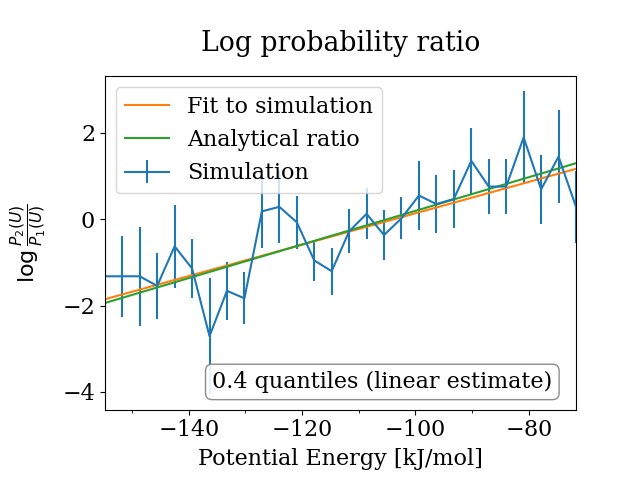

Maximum Likelihood Analysis (analytical error)
Free energy
    5.40765 +/- 0.60277
Estimated slope                  |  True slope
    0.038921  +/- 0.005296       |  0.038936 
    (0.00 quantiles from true slope)
Estimated dT                     |  True dT
    32.3   +/- 4.4               |  32.3  
After equilibration, decorrelation and tail pruning, 16.33% (490 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 15.93% (478 frames) of original Trajectory 2 remain.
Overlap is 95.7% of trajectory 1 and 92.5% of trajectory 2.
Rule of thumb estimates that dT = 63.9 would be optimal (currently, dT = 35.7)


<IPython.core.display.Javascript object>


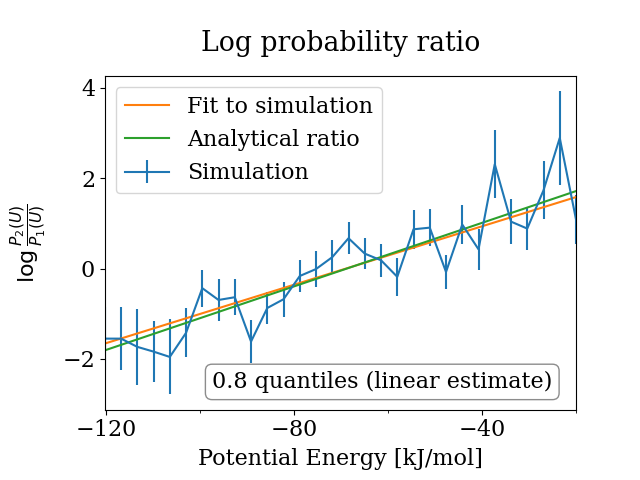

Maximum Likelihood Analysis (analytical error)
Free energy
    2.36236 +/- 0.21589
Estimated slope                  |  True slope
    0.035230  +/- 0.002913       |  0.035155 
    (0.03 quantiles from true slope)
Estimated dT                     |  True dT
    35.8   +/- 3.0               |  35.7  
After equilibration, decorrelation and tail pruning, 15.93% (478 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 9.20% (276 frames) of original Trajectory 2 remain.
Overlap is 96.2% of trajectory 1 and 93.1% of trajectory 2.
Rule of thumb estimates that dT = 71.6 would be optimal (currently, dT = 39.6)


<IPython.core.display.Javascript object>


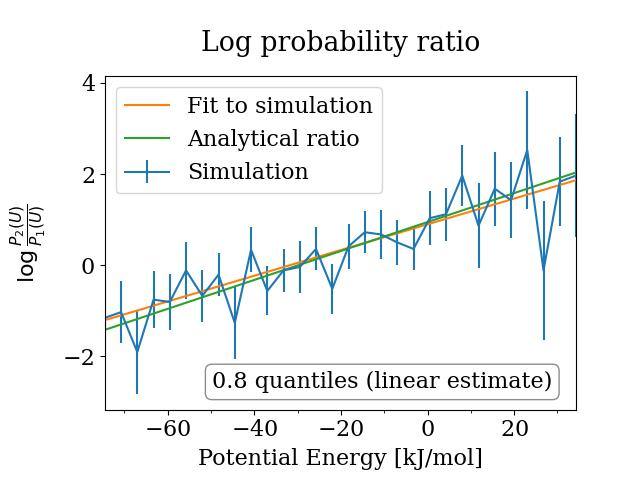

Maximum Likelihood Analysis (analytical error)
Free energy
    0.34585 +/- 0.14426
Estimated slope                  |  True slope
    0.030943  +/- 0.003609       |  0.031740 
    (0.22 quantiles from true slope)
Estimated dT                     |  True dT
    38.6   +/- 4.5               |  39.6  
After equilibration, decorrelation and tail pruning, 9.20% (276 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 6.30% (189 frames) of original Trajectory 2 remain.
Overlap is 81.2% of trajectory 1 and 97.4% of trajectory 2.
Rule of thumb estimates that dT = 81.0 would be optimal (currently, dT = 43.8)


<IPython.core.display.Javascript object>


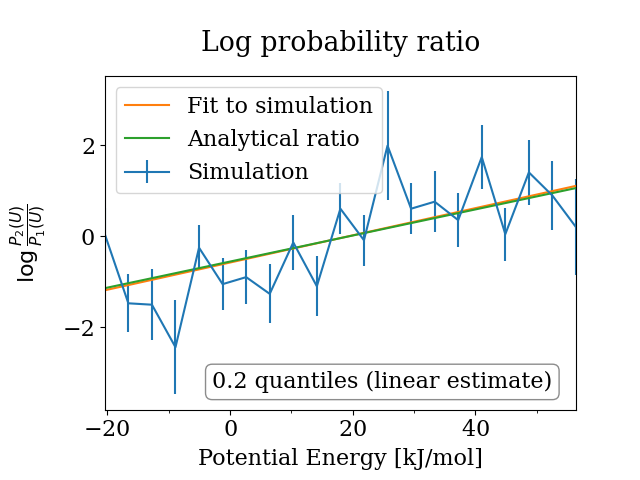

Maximum Likelihood Analysis (analytical error)
Free energy
    -0.79533 +/- 0.14068
Estimated slope                  |  True slope
    0.030647  +/- 0.003797       |  0.028658 
    (0.52 quantiles from true slope)
Estimated dT                     |  True dT
    46.9   +/- 5.8               |  43.8  
After equilibration, decorrelation and tail pruning, 6.30% (189 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 7.00% (210 frames) of original Trajectory 2 remain.
Overlap is 92.6% of trajectory 1 and 100.0% of trajectory 2.
Rule of thumb estimates that dT = 96.4 would be optimal (currently, dT = 48.6)


<IPython.core.display.Javascript object>


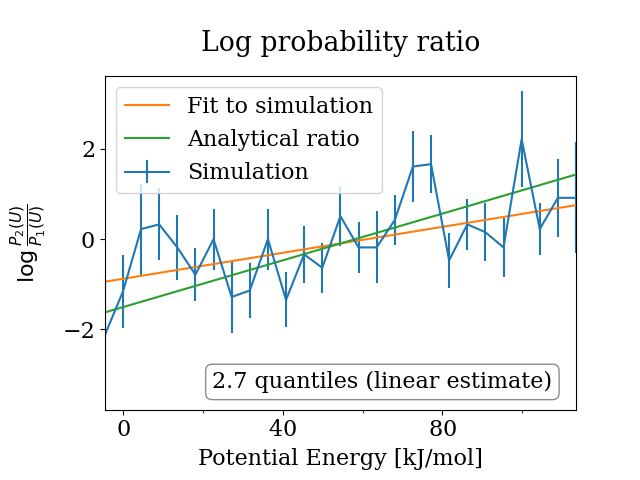

Maximum Likelihood Analysis (analytical error)
Free energy
    -0.96215 +/- 0.23485
Estimated slope                  |  True slope
    0.019539  +/- 0.003492       |  0.025875 
    (1.81 quantiles from true slope)
Estimated dT                     |  True dT
    36.7   +/- 6.6               |  48.6  


In [9]:
for simulation_lower, simulation_upper in zip(
    simulation_data[:-1], simulation_data[1:]
):
    physical_validation.ensemble.check(
        data_sim_one=simulation_lower, data_sim_two=simulation_upper, screen=True
    )

In this analysis, we observe satisfactory dependence of the ensemble distribution on the temperature. As a rule of thumb, if the true interval is not within about 2-3 standard deviations of the estimated interval, the trajectory is unlikely to have been sampled from the expected ensemble. All intervals are below 2 quantiles from the true slope in the maximum likelihood analysis, the first four are around or below 0.5 quantiles from the true slope.